### Imports

In [143]:
import numpy as np
from bond_pricing import annuity_rate, bond_coupon_periods, bond_price_breakup, equiv_rate, bond_yield
import isda_daycounters

### No-Arbitrage Price - Spot Curve

The starting place in no‐arbitrage bond valuation is the zero‐coupon (or spot) yield curve and these rates are used to value coupon bonds.

No-arbitrage price for a 4-year, 4% annual coupon payment corporate bond.

Assume that the sequence of zero-coupon bond yields is `[3.5%, 3.8%, 4.1%, and 4.2%]`, an upward-sloping spot curve. (“Spot rate” is a commonly used synonym for zero‐coupon rate.)

Generalization of the bond pricing equation:
$$PV=\frac{PMT}{(1+\mathit{z}_{1})^{1}}+\frac{PMT}{(1+\mathit{z}_{2})^{2}}+ \cdots + \frac{PMT+PV}{(1+\mathit{z}_{N})^{N}}$$

PV is the no‐arbitrage value of the N‐period bond—the sum of the present values of the cash flows, each of which is discounted using the zero‐coupon rate that corresponds to the period ($\mathit{z}_{1}, \mathit{z}_{2}, \cdots, \mathit{z}_{N}$), PMT is the coupon payment per period, and FV is the principal (usually taken to be 100 so the price can be interpreted as the percentage of par value).

Given a particular bond price, the yield to maturity is the internal rate of return (IRR) on the cash flows. An IRR is the uniform discount rate such that the sum of the present values of the future cash flows discounted at that particular interest rate for each time period equals the price of the bond.

The correct way to think about a **yield to maturity is as a summary statistic** about the cash flows on the bond which does not presume a flat yield curve. It is a **present value weighted average** of the sequence of zero‐coupon rates with most of the weight on the last cash flow. 

In [2]:
spot_rates1 = np.array([0.035, 0.038, 0.041, 0.042])
coupon_rate = 0.04
fv = 100
years = 4
per = 1

def bond_price_spot_rate(coupon_rate, fv, years, per, spot_rates):
  coupon = fv * coupon_rate * per 
  cash_flows = np.full(years, coupon) 
  cash_flows[years-1] += fv
  period = np.arange(1, years+1)
  pv_cf = cash_flows / (1 + spot_rates/per)**(period*per)
  return np.sum(pv_cf)

pv = bond_price_spot_rate(coupon_rate=coupon_rate, fv=fv, years=years, per=per, spot_rates=spot_rates1)
print(f'{pv = :0.3f}')
ytm = annuity_rate(n_periods=years, instalment=fv*coupon_rate, pv=pv, terminal_payment=fv)
print(f'{ytm = : 0.5f}')

pv = 99.342
ytm =  0.04182


In [3]:
spot_rates1 = np.array([0.035, 0.038, 0.041, 0.042]) # upward sloping zero-coupon curve
spot_rates2 = np.array([0.0492, 0.0469, 0.043, 0.0416]) # downward sloping spot curve
spot_rates3 = np.array([0.0213, 0.0282, 0.0365, 0.0425])
spot_rates4 = np.array([0.04182, 0.04182, 0.04182, 0.04182])

rates = [spot_rates1, spot_rates2, spot_rates3, spot_rates4]

for spot_rate in rates:
  pv = bond_price_spot_rate(coupon_rate=coupon_rate, fv=fv, years=years, per=per, spot_rates=spot_rate)
  print(f'{pv = :0.3f}')

pv = 99.342
pv = 99.342
pv = 99.342
pv = 99.342


### Bond Prices and Yields

The yield to maturity ($\mathit{y}$) per period is the internal rate of return given the cash flows.

$$PV=\frac{PMT}{(1+\mathit{y})^{1}}+\frac{PMT}{(1+\mathit{y})^{2}}+ \cdots + \frac{PMT+PV}{(1+\mathit{y})^{N}}$$

$$PV=\frac{PMT}{y}\times\left[1 - \frac{1}{(1+y)^{N}}\right]+\frac{FV}{(1+y)^{N}}$$

$$\frac{PV-FV}{FV}=\frac{c-y}{y}\times\left[1-\frac{1}{(1+y)^{N}}\right]$$

Here *c* is the coupon rate per period, PMT/FV. This expression indicates the connection between the price of the bond vis‐à‐vis par value and the coupon rate vis‐à‐vis the yield to maturity. These are the well‐known (and well‐remembered) rules: (1) If the bond is priced at par value (*PV = FV*), the coupon rate and the yield to maturity are equal (*c = y*); (2) if the price is a discount below par value (*PV < FV*), the coupon rate is less than the yield (*c < y*); and (3) if the price is a premium above par value (*PV > FV*), the coupon rate is greater than the yield (*c > y*). These rules apply to a coupon payment date when *N* is an integer.

Alternative arrangement of the bond pricing equation:
$$PV=PMT\left(\frac{1-(1+y)^{-N}}{y}\right)+\frac{FV}{(1+y)^N}$$
$$FV_{n}=PMT\left[\frac{(1+y)^{N}-1}{y}\right]+TV$$
$$PMT=\left[\frac{PV - \frac{FV}{(1+y)^N}}{\frac{1-(1+y)^{-N}}{y}}\right]$$

In [4]:
def pv(r, n, pmt, fv, beg=False):
  old_settings = np.seterr(invalid='ignore')
  pvPMT = np.where(r == 0, n, np.divide(1 - (1+r)**-n, r)) * pmt
  np.seterr(**old_settings)
  pvFV = fv / (1 + r)**n
  
  return np.where(beg, (pvPMT + pvFV) * (1 + r), pvPMT + pvFV)

def fv(r, n, pmt, terminal_payment, beg=False):
  old_settings = np.seterr(invalid='ignore')
  fvPMT = np.where(r == 0, n, np.divide((1+r)**n - 1, r)) * pmt
  np.seterr(**old_settings)
  TV = terminal_payment
  
  return np.where(beg, fvPMT * (1 + r) + TV, fvPMT + TV)

def pmt(r, n, pv, fv):
    return (pv - (fv/(1+r)**n)) / np.divide(1 - (1+r)**-n, r)

### Yield Statistics

- **Yield-to-Maturity** is also called the *Redemption Yield*.
  - YTM is typically stated in *street convention* such that regardless of whether the future cash flow dates fall on a holiday/weekend, it is considered to be received in regular intervals. This convention produces an IRR using integers as exponents.
  - *True yield* statistics solves the IRR given the specific calendar dates for cash flows based on some schedule of bank holidays.
- **Current Yield** also called the *running yield* and the *income yield*; it is the annual coupon payment divided by the price of the bond. 
  - $\text{Coupon Yield}=\frac{PMT}{PV}$
- **Simple Yield** also called the *Japanese* simple yield; it is the coupon payment plus the straight-line amortization of the gain (buying at discount) or loss (buying at premium) divided by the price of the bond. 
  - $\text{Simple Yield}=\frac{PMT + \left(\frac{FV - PV}{N}\right)}{PV}$
- **Approx. Yield to Maturity** is divides the coupon payment and the straight-line amortization of the gain/loss by the average of the current price and the redemption payment. 
  - $\text{Approx. Yield-to-Maturity}=\frac{PMT + \left(\frac{FV - PV}{N}\right)}{\frac{PV + FV}{2}}$
  - This approximation is usually used as the first 'guess' or starting place in the trial-and-error search algorithms that determine the IRR where NPV of cash flows equates to 0 (Newton's method, binary search, etc.)
- **U.S. Government Equivalent** is a recalibrated yield using an actual/actual day-count convention instead of 30/360. 

In [6]:
N = 4
presentvalue = 99.342
facevalue = 100
coupon = 4

def current_yield(pmt, pv):
    return pmt / pv

def simple_yield(pv, fv, N, pmt):
    return (pmt + (fv  - pv)/N) / pv

def approx_ytm(pv, fv, N, pmt):
    return (pmt + (fv  - pv)/N) / ((pv + fv)/2)

def equivRate(rate, from_freq=1, to_freq=1):
  if from_freq == np.inf:
    return (np.exp(rate / to_freq) - 1) * to_freq
  elif to_freq == np.inf:
    return np.log(1 + rate / from_freq) * from_freq
  else:
    rate = np.log(1 + rate / from_freq) * from_freq
    return (np.exp(rate / to_freq) - 1) * to_freq

print(current_yield(coupon, presentvalue))
print(simple_yield(presentvalue, facevalue, N, coupon))
print(approx_ytm(presentvalue, facevalue, N, coupon))

0.04026494332709227
0.04192083912141894
0.04178246430757192


### Horizon Yields

Horizon yield (holding period rate of return) analysis can be done ex-ante using projected future rates or ex-post using actual realized rates. The analysis considers price and **yield at the time of sale** of the bond (if sold before maturity), which reflects the future buyer's required rate of return to hold the bond for the remainder of the time to maturity, and the **coupon payment reinvestment rate** (assuming constant coupon reinvestment rate (CRR)).

Holding period return (HPR) over the time to maturity depends only on the CRR. When the bond is sold prior to maturity, the HPR is a function also of the price (and yield) at the time of sale. The objective here is to see the connection between the HPR and the traditional YTM (yield to maturity) statistic.

That total return is the sum of the reinvested coupon payments plus the final coupon and principal. The first coupon is reinvested for three years, the second for two years, and the third for one year.

$$\text{Total Return}=\left[PMT\times\left(1+CRR\right)^{N-1}\right]+\left[PMT\times\left(1+CRR\right)^{N-2}\right]+\cdots+\left[PMT\times\left(1+CRR\right)^{N-(N-1)}\right]+FV$$
Suppose that CRR = YTM
$$\text{Total Return}=PMT\left[\frac{(1+y)^{N}-1}{y}\right]+FV$$

Solve for the horizon yield—the annual rate of return that connects the purchase price and the total return at maturity.
$$\text{HPR}=\left[\left(\frac{\text{Total Return}}{PV}\right)^{\frac{1}{N\times PER}}-1\right]\times PER$$

This equation shows the well‐known result that the yield to maturity measures the **investor’s rate of return only if the coupons are reinvested at that same yield**. This is a standard caveat for internal rates of return in general.

Formalized as follows:
- If CRR = YTM, then HPR = YTM.
- If CRR > YTM then HPR > YTM.
- If CRR < YTM then HPR < YTM.

In [7]:
years = 4
coupon = 4
principal = 100
ytm = 0.04182 

total_return = fv(ytm, years, coupon, principal, beg=False)
print(f'{total_return :0.3f}')

117.032


### Implied Probability of Default on Coupon Bonds

In [8]:
per = 1

# 4-year, 4% annual payment corporate bond
cop_mat = 4
cop_pv = 99.342
coupon = 4
cop_yield = annuity_rate(n_periods=cop_mat, instalment=coupon, pv=cop_pv, terminal_payment=100)

# Equivalent 10-year government bond
gov_mat = 4
gov_yield = 0.035
gov_pv = pv(gov_yield, gov_mat, coupon, 100)

credit_spread = cop_yield - gov_yield
price_spread = gov_pv - cop_pv

In [9]:
from prettytable import PrettyTable

# Probability of Default Calculation - Unconditional Probability
year = np.arange(1, cop_mat+1)
probability_default = ['Q' for _ in year]

# Risk-Free Value (value of the corporate bond if it were risk free, coupon payments at the beginning of the period)
riskfree_value = np.array([np.round(pv(gov_yield, gov_mat - i + 1, coupon, 100, beg=True), 3) for i in year])

# Recovery assuming a recovery rate of 40% of par value (unlike zero-coupon bond, recovery is a constant fraction of par instead of risk-free value)
recovery_rate = 0.4 # Depending on the industry and the rank of the bond in the debt structure
recovery = np.array([round(100 * recovery_rate, 3) for _ in year])

# Default Loss after instantaneous recovery - loss at the time if default occurs—it is the riskfree value minus recovery
default_loss = np.array([round(riskfree_value[i-1] - recovery[i-1], 3) for i in year])

# Present value of default loss - risk-free rate is used to discount the losses
pv_default = np.array([round(default_loss[i-1]/((1+gov_yield/per)**(i*per)),3) for i in year])
# Here the present values turn out to be the same for each year—that’s because the bond is zero-coupon 
# and the recovery rate is assumed to be a constant share of the loss.

# Present Value of Expected Loss
expected_loss = np.array([str(default) + ' * Q' for default in pv_default])

# Output Table
table = PrettyTable()
table.add_column("Year", year)
table.add_column("Prob. of Default", probability_default)
table.add_column("Risk-Free Value", riskfree_value)
table.add_column("Recovery", recovery)
table.add_column("Default Loss", default_loss)
table.add_column("PV of Default Loss", pv_default)
table.add_column("Expected Loss", expected_loss)
print(table)

Q = price_spread/np.sum(pv_default) # implied default probability
print(f'{Q = :%}')

approx_implied_default_prob = credit_spread/(1 - recovery_rate)
print(f'{approx_implied_default_prob = :%}')

+------+------------------+-----------------+----------+--------------+--------------------+---------------+
| Year | Prob. of Default | Risk-Free Value | Recovery | Default Loss | PV of Default Loss | Expected Loss |
+------+------------------+-----------------+----------+--------------+--------------------+---------------+
|  1   |        Q         |     105.401     |   40.0   |    65.401    |       63.189       |   63.189 * Q  |
|  2   |        Q         |      104.95     |   40.0   |    64.95     |       60.632       |   60.632 * Q  |
|  3   |        Q         |     104.483     |   40.0   |    64.483    |       58.16        |   58.16 * Q   |
|  4   |        Q         |      104.0      |   40.0   |     64.0     |       55.772       |   55.772 * Q  |
+------+------------------+-----------------+----------+--------------+--------------------+---------------+
Q = 1.049215%
approx_implied_default_prob = 1.136751%


### Bond Pricing Between Coupon Dates

Suppose that the current coupon period covers $T$ days and that the bond is being priced for settlement $t$ days into the period. Therefore, $t/T$ is the fraction of the period that has gone by and $1 – t/T$ is the fraction that remains.

General version of the formula:
$$\text{Flat} + \text{AI} = \frac{PMT}{(1+y)^{1-t/T}} + \frac{PMT}{(1+y)^{2-t/T}} + \cdots + \frac{PMT + FV}{(1+y)^{N-t/T}}$$

The next coupon payment is discounted back over the fraction of the period ($1 – t/T$) until that cash flow is received; the following payment adds a full period to that fraction ($2 – t/T$), and so forth.

The left side is the sum of the present values of the cash flows and is the full price for the bond on the settlement date. That **full price**, which often is called the **dirty or invoice price** in practice, is decomposed into the **flat price** ($Flat$), which also is called the **clean price**, and the **accrued interest** ($AI$).

Accrued interest is the compensation to the seller of the bond for interest income since the last coupon date. It is calculated as a straight‐line share of the forthcoming payment. It is the fraction of the period that has elapsed times the amount of the payment.

$$AI=t/T\times PMT$$

Determining the fraction $t/T$ depends on the day‐count convention specified in the bond’s documentation.

Multiply the numerator and denominator by $(1 + y)^{t/T}$ in equation above and substitute in equations full price equation to get a general closed‐form relationship between the present and future cash flows and the yield‐to‐maturity statistic.

$$\text{Flat} + (t/T \times PMT) = \left[\frac{PMT}{y} \times \left(1-\frac{1}{(1+y)^{N}}\right) + \frac{FV}{(1+y)^{N}}\right]\times (1+y)^{t/T}$$
$$\text{Flat} + (t/T \times PMT) =\left[PMT\left(\frac{1-(1+y)^{-N}}{y}\right)+\frac{FV}{(1+y)^N}\right] \times (1+y)^{t/T}$$

In [198]:
from pandas import to_datetime

issuance = to_datetime('2010-11-15')
settlement = to_datetime('2011-02-14')
maturity = to_datetime('2020-11-15')
daycount = 'thirty/360'
installment = 8
y = 0.08
facevalue = 100
N = 10
per = 2

coupon_periods = bond_coupon_periods(settle=settlement, mat=maturity, freq=2, daycount=daycount)
print("{" + ",\n".join("{!r}: {!r}".format(k, v) for k, v in coupon_periods.items()) + "}")

price_breakup = bond_price_breakup(settle=settlement, cpn=installment/100, mat=maturity,
               yld=y, freq=2, comp_freq=2,
               face=100, redeem=facevalue, daycount=daycount)

print()
print("{" + ",\n".join("{!r}: {!r}".format(k, v) for k, v in price_breakup.items()) + "}")

print()
tT = coupon_periods['accrual_fraction']
accrued_interest = (tT * installment/per)
print(f'{accrued_interest = :0.5f}')
flat_price = (pv(y/per, N*per, installment/per, facevalue) * (1 + y/per)**tT) - accrued_interest
print(f'{flat_price = }')
full_price = (pv(y/per, N*per, installment/per, facevalue) * (1 + y/per)**tT)
print(f'{full_price = }')

{'n': 20,
'discounting_fraction': 0.5055555555555555,
'accrual_fraction': 0.49444444444444446,
'next_coupon': Timestamp('2011-05-15 00:00:00'),
'prev_coupon': Timestamp('2010-11-15 00:00:00')}

{'DirtyPrice': 101.95817189458909,
'AccruedInterest': 1.9777777777777779,
'CleanPrice': 99.98039411681131,
'NextCoupon': Timestamp('2011-05-15 00:00:00'),
'PreviousCoupon': Timestamp('2010-11-15 00:00:00')}

accrued_interest = 1.97778
flat_price = 99.98039411681131
full_price = 101.95817189458909


In [203]:
def gov_equiv_yield(y, N, pmt, price, fv, per, tT):
    from scipy.optimize import newton
    
    def f(y): # The function whose zero is to be found
        return (pv(y/per, N*per, pmt/per, fv) * (1 + y/per)**tT) - price
    
    root, status = newton(f, y, full_output=True, disp=False)
    return root, status

coupon_periods = bond_coupon_periods(settle=settlement, mat=maturity, freq=2, daycount='actual/actual')
print(settlement - coupon_periods['prev_coupon'])
print(coupon_periods['next_coupon'] - coupon_periods['prev_coupon'])
print(coupon_periods['accrual_fraction'])
print(91/181)
print(gov_equiv_yield(y, N, installment, full_price, facevalue, per, tT))


print(isda_daycounters.actualactual.year_fraction(coupon_periods['prev_coupon'], settlement)*2)
print(isda_daycounters.thirty360.year_fraction(coupon_periods['prev_coupon'], settlement)*2)

91 days 00:00:00
181 days 00:00:00
0.4986301369863014
0.5027624309392266
(0.08,       converged: True
           flag: converged
 function_calls: 3
     iterations: 2
           root: 0.08
         method: secant)
0.4986301369863014
0.49444444444444446


pv_0 = array(3.84615385)
pv_89 = array(3.92146815)


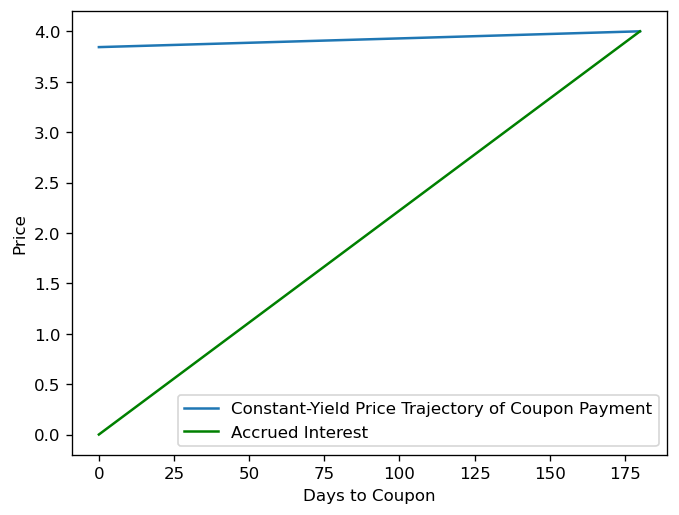

In [142]:
import matplotlib.pyplot as plt

# Present Value of the 1st Coupon Payment - At Issuance 
futurevalue = 4
ytm = 0.08 # semiannual periodicity
ytm_daily = equiv_rate(ytm, from_freq=2, to_freq=360)
n = 180  
pv_0 = pv(ytm_daily/360, n, 0, futurevalue)
print(f'{pv_0 = }')

# Present Value of the 1st Coupon Payment - 89 Days After Issuance
pv_89 = pv(ytm_daily/360, n - 89, 0, futurevalue)
print(f'{pv_89 = }')

n_x = np.linspace(180, 0, num=180)

pv_y = pv(ytm/360, n_x, 0, futurevalue)
accrued_y = n_x/180 * futurevalue

plt.figure(num=0, dpi=120)
plt.plot(180-n_x, pv_y, label='Constant-Yield Price Trajectory of Coupon Payment')
plt.plot(n_x, accrued_y, "g", label="Accrued Interest")
plt.xlabel('Days to Coupon')
plt.ylabel('Price')
plt.legend()